In [ ]:
'''!pip install transformers
!pip install tensorflow
!pip install keras
!pip install Sentencepiece
!pip install torch
!pip install datasets
!pip install -U scikit-learn'''

In [15]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [1]:
import transformers
import torch
import keras
from datasets import load_dataset, concatenate_datasets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functions import *

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer

2022-05-18 09:47:50.984812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 09:47:50.984830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

In [ ]:
import wandb

In [2]:
#forum_vals, forum_trains = load_and_tokenize_training_set("1-forum-only/Forum_label_train.csv")
forum_vals, forum_trains = load_and_tokenize_training_set("3-mixed_predicted/8_percent_mixed.csv")

Using custom data configuration default-cf927cfc7fafb096


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-cf927cfc7fafb096/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/10 [00:00<?, ?it/s]

Using custom data configuration default-cf927cfc7fafb096
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-cf927cfc7fafb096/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

In [3]:
training_args = TrainingArguments("undersampled_forum", evaluation_strategy="epoch")

In [ ]:
metrics = {}

for i in range(10):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=3)
    wandb.init(project="CUI-undersampled", entity="sel", tags=["8_percent_mixed", str(i)])
    wandb.watch(model)
    trainer = Trainer(model=model, args=training_args, train_dataset=forum_trains[i], eval_dataset=forum_vals[i], compute_metrics=compute_metrics)
    trainer.train()
    wandb.finish()
    metrics[i] = {}
    forum_preds = load_predict_testset("1-forum-only/Forum_label_test.csv", trainer=trainer)
    synth_preds = load_predict_testset("2-synthetic-only/synthetic_test_gpt_labels_as_qs.csv", trainer=trainer)
    mix_pred = load_predict_testset("3-mixed_predicted/mixed_test_as_pred.csv", trainer=trainer)
    mix_qs_pred = load_predict_testset("4-mixed_lab_q/mixed_test_as_q.csv", trainer=trainer)
    metrics[i]["forum"] = compute_test_metrics(forum_preds, 'macro')
    metrics[i]["synthetic"] = compute_test_metrics(synth_preds, 'macro')
    metrics[i]["mixed_predicted"] = compute_test_metrics(mix_pred, 'macro')
    metrics[i]["mixed_as_q"] = compute_test_metrics(mix_qs_pred, 'macro')
    print(metrics[i])

trainer.save_model("classifs/mixed_predicted/mixed_8_percent_model")

In [7]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                           for i in metrics.keys() 
                           for j in metrics[i].keys()},
                       orient='index')


metrics_df.head()

accuracy        f1  precision    recall
0 forum            0.784127  0.654351   0.760933  0.613730
  synthetic        0.820340  0.722570   0.808659  0.685071
  mixed_predicted  0.909107  0.856473   0.905676  0.820919
  mixed_as_q       0.814754  0.713497   0.803616  0.674033
1 forum            0.776720  0.678722   0.726169  0.648790

In [8]:
metrics_df.to_csv("metrics_test/mixed_8_percent_classifier_metrics.csv")

In [10]:
forum_test = load_predict_testset("1-forum-only/Forum_label_test.csv", model_path="classifs/synthetic_only/model")

Using custom data configuration default-9d0b1995afead408
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-9d0b1995afead408/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-9d0b1995afead408/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-336a11cd5b807abc.arrow


In [14]:
compute_test_metrics(forum_test, 'macro')

{'accuracy': 0.7481481481481481,
 'f1': 0.6282817021947457,
 'precision': 0.6823577894525906,
 'recall': 0.6006151701338868}

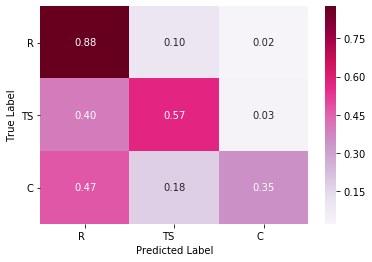

In [12]:
cm = confusion_matrix(forum_test.label_ids, forum_test.predictions.argmax(-1))
show_confusion_matrix(cm, normalized=True, class_names=["R", "TS", "C"])

### Classify synthetic data with confidence Intervals

In [3]:
gpt_train = pd.read_csv("synthetic_train_gpt_labels_as_qs.csv", index_col="Unnamed: 0")
gpt_test = pd.read_csv("synthetic_test_gpt_labels_as_qs.csv", index_col="Unnamed: 0")
sentences_train = gpt_train["Sentence"].to_list()
sentences_test = gpt_test["Sentence"].to_list()

In [8]:
splitted_train = np.array_split(sentences_train, 10)

In [21]:
splitted_train[0]

array([' Ich denke, ich habe mich schon immer ein bisschen zu viel gefühlt.',
       ' Ich finde es wichtig mein Gewicht zu reduzieren, da ich einige gesundheitliche Probleme habe.',
       ' Ich muss wieder zurück zu meinen Wurzeln gehen.', ...,
       ' Ich weiß einfach nicht, was ich tun soll.', ' Hallo!',
       ' Ich vermeide Fett, Zucker, Salz und Alkohol.'], dtype='<U256')

In [6]:
from transformers import TextClassificationPipeline

cuda = torch.device('cuda')
model = AutoModelForSequenceClassification.from_pretrained("classifs/forum_only/model", local_files_only=True).cuda()
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)

In [ ]:
label_0_scores = []
label_1_scores = []
label_2_scores = []

for entry in splitted_train:
    print(entry)
    with pipe.device_placement():
        torch.cuda.empty_cache()
        predictions_train = pipe(list(entry), truncation=True, batch_size=4)
        for entry in predictions_train:
            label_0_scores.append(entry[0]['score'])
            label_1_scores.append(entry[1]['score'])
            label_2_scores.append(entry[2]['score'])

In [19]:
#len(label_0_scores)
pred_train_df = pd.DataFrame({"Sentence": sentences_train, "0_R":label_0_scores, "1_TS": label_1_scores, "2_C": label_2_scores })

In [23]:
pred_train_df.to_csv("synthetic_train_predicted_confidence.csv")

In [4]:
splitted_test = np.array_split(sentences_test, 2)

In [7]:
label_0_scores = []
label_1_scores = []
label_2_scores = []

for entry in splitted_test:
    print(entry)
    with pipe.device_placement():
        torch.cuda.empty_cache()
        predictions_train = pipe(list(entry), truncation=True, batch_size=4)
        for entry in predictions_train:
            label_0_scores.append(entry[0]['score'])
            label_1_scores.append(entry[1]['score'])
            label_2_scores.append(entry[2]['score'])
    
pred_test_df = pd.DataFrame({"Sentence": sentences_test, "0_R":label_0_scores, "1_TS": label_1_scores, "2_C": label_2_scores })

[' Ich wünsche mir mehr Kontrolle über meine Ernährung.'
 ' Ich habe mich ein wenig gesünder ernährt.'
 ' Welche Möglichkeiten siehst du, um etwas gegen dieses Gefühl der Anstrengung zu unternehmen?'
 ...
 ' Ich würde gerne wieder mehr Sport treiben, aber ich weiß nicht, wie ich das anfangen soll.'
 ' Ich müsste mehr Zeit haben um mich zu bewegen.'
 ' Ich habe einige Wochen zuvor begonnen, meine Ernährung umzustellen.']
[' Ich bin so müde von der ganzen Arbeit, die ich in meinen Körper investiere und ich möchte endlich Ergebnisse sehen.'
 ' Ich möchte gesund leben und mich auch so fühlen.'
 ' Auch die Geschwindigkeit, mit der ich esse, könnte ich einschränken.'
 ... ' Hallo!' ' Meine Ernährung hat sich sehr verbessert.'
 ' Ich könnte mein Essen einfach nur ansehen und dann wüsste ich, wie viel ich esse.']


In [10]:
pred_test_df.to_csv("synthetic_test_predicted_confidence.csv")

NameError: name 'pred_test_df' is not defined

In [4]:
forum_vals, forum_trains = load_and_tokenize_training_set("sublabels/train_sublabels_synthetic_noR.csv")
training_args = TrainingArguments("test", evaluation_strategy="epoch")

for i in range(2):
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=3)
    trainer = Trainer(model=model, args=training_args, train_dataset=forum_trains[i], eval_dataset=forum_vals[i], compute_metrics=compute_metrics)
    trainer.train()
    forum_preds = load_predict_testset("sublabels/sublabels_forum_test_noR.csv", trainer=trainer)
    synthetic_preds = load_predict_testset("sublabels/test_sublabels_synthetic_noR.csv", trainer=trainer)
    print("Forum: ")
    print(compute_test_metrics(forum_preds, 'macro'))
    print("Synthetic: ")
    print(compute_test_metrics(synthetic_preds, 'macro'))

Using custom data configuration default-72b5b6a0301140a8


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jovyan/.cache/huggingface/datasets/csv/default-72b5b6a0301140a8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/10 [00:00<?, ?it/s]

Using custom data configuration default-72b5b6a0301140a8
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-72b5b6a0301140a8/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

test


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.817654,0.783783,0.631480,0.621836,0.633728,0.622887
2,0.709786,0.760802,0.664467,0.664638,0.680386,0.665189


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

wandb: WARNING Step must only increase in log calls.  Step 3500 < 3585; dropping {'train/loss': 0.54496630859375, 'train/learning_rate': 1.1446119486320492e-06, 'train/epoch': 2.931323283082077}.
wandb: WARNING Step must only increase in log calls.  Step 3582 < 3585; dropping {'eval/loss': 0.9245823621749878, 'eval/accuracy': 0.6365348399246704, 'eval/f1': 0.6317549258129733, 'eval/precision': 0.6393461699061054, 'eval/recall': 0.6392218454953957, 'train/epoch': 3.0}.
wandb: WARNING Step must only increase in log calls.  Step 3582 < 3585; dropping {'train/total_flos': 9602768188588032, 'train/epoch': 3.0}.
Using custom data configuration default-ac5cb7352c4ec37c
Reus

  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-ac5cb7352c4ec37c/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-32020e421c50ad77.arrow


Using custom data configuration default-a69c280ab7593910
Reusing dataset csv (/home/jovyan/.cache/huggingface/datasets/csv/default-a69c280ab7593910/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/csv/default-a69c280ab7593910/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-781474f715c0055e.arrow


Forum: 
{'accuracy': 0.4973821989528796, 'f1': 0.4968102332403128, 'precision': 0.5303703703703704, 'recall': 0.5557579515799809}
Synthetic: 
{'accuracy': 0.6661642803315749, 'f1': 0.664107899905828, 'precision': 0.6710721623607286, 'recall': 0.6677061986680758}
